Continuous-time model
---

Let's order the infection times $t_{\pi_{1}}<t_{\pi_{2}}<\dots<t_{\pi_{N}}$
. Let $\lambda_{i}\left(t\right)$ be a time-dependent transmission
rate and $L_{i}\left(t\right)=\int_{0}^{t}\lambda_{ij}\left(s\right)ds$
its primitive. Then $\rho_{i}\left(t_i; t_j\right)=\lambda_{i}\left(t_i\right)e^{-\int_{t_j}^{t_i}\lambda_{i}\left(s\right)ds} = \lambda_{i}\left(t_j\right)e^{L_{i}(t_j) - L_{i}(t_i) }$
will be the transmission ``delay'' density distribution. 

\begin{align*}p\left(t_{1},\dots,t_{N}\right) & =\prod_{i=1}^{N}\lim_{ds\to0^{+}}\frac{\prod_{j\in\partial i:t_{j}<t_{i}}e^{L_{i}(t_{j})-L_{i}(t_{i}-ds)}-\prod_{j\in\partial i:t_{j}<t_{i}}e^{L_{i}(t_{j})-L_{i}(t_{i})}}{ds}\\
 & =\prod_{i=1}^{N}\frac{d}{ds}_{|s=0}\prod_{j\in\partial i:t_{j}<t_{i}}e^{L_{i}(t_{j})-L_{i}(t_{i}-ds)}\\
 & =\prod_{i=1}^{N}\left\{ \left(\prod_{j\in\partial i:t_{j}<t_{i}}e^{L_{i}(t_{j})-L_{i}(t_{i})}\right)\sum_{j\in\partial i:t_{j}<t_{i}}\lambda_{i}\left(t_{i}\right)\right\} \\
\mathcal{L}_{0}\left(t_{1},\dots,t_{N}\right) & =\log p\left(t_{1},\dots,t_{N}\right)\\
 & =-\sum_{i=1}^{N}\left\{ \sum_{j\in\partial i:t_{j}<t_{i}}\left(L_{i}(t_{i})-L_{i}(t_{j})\right)-\log\left(\sum_{j\in\partial i:t_{j}<t_{i}}\lambda_{i}\left(t_{i}\right)\right)\right\} 
\end{align*}

Note that $$\int_{t_j}^{t_i} \rho_{i}(s; t_j) ds = 1-e^{-\left(L_{i}(t_i) - L_{i}(t_j)\right)}$$ so $$\lambda_{i}(t) = -\frac{d}{dt}\log \left(1-\int_{t_j}^{t_i} \rho_{i}(s) ds\right)$$


\begin{align}\lambda(t) & =ae^{-\left(\frac{t-b}{c}\right)^{2}}\\
\frac{x-b}{c} & =\frac{y}{\sqrt{2}}\\
dx & =\frac{c}{\sqrt{2}}dy\\
L(t)=\int_{0}^{t}ae^{-\left(\frac{x-b}{c}\right)^{2}}dx & = ac\int_{\frac{0-b}{c}}^{\frac{t-b}{c}}e^{-y^{2}}dy\\
 & =ac\sqrt{\pi}\frac{1}{\sqrt{\pi}}\int_{-\frac{b}{c}}^{\frac{t-b}{c}}e^{-y^{2}}dy\\
 & =\frac{ac\sqrt{\pi}}{2}\left(\mathrm{erfc}\left(-\frac{t-b}{c}\right)-\mathrm{erfc}\left(\frac{b}{c}\right)\right)\\
\rho_{i}\left(t_{i};t_{j}\right) & =\lambda_{i}\left(t_{i}\right)e^{-\int_{t_{j}}^{t_{i}}\lambda_{i}\left(s\right)ds}=\lambda_{i}\left(t_{i}\right)e^{L_{i}(t_{j})-L_{i}(t_{i})}\\
\frac{d}{ds}-e^{L_{i}(t_{j})-L_{i}(s)} & =\lambda\left(s\right)e^{L_{i}(t_{j})-L_{i}(s)}=\rho_{i}\left(s;t_{j}\right)\\
\end{align}

Sampling 
---
\begin{align}
\int_{t_{j}}^{t}\rho(s;t_{j})ds & =1-e^{L_{i}(t_{j})-L_{i}(t)}=1-r\sim U(0,1)\\
e^{L_{i}(t_{j})-L_{i}(t)} & =r\\
L_{i}(t) & =L_{i}\left(t_{j}\right)-\log(r)\\
\mathrm{erfc}\left(-\frac{t-b}{c}\right) & =\frac{2}{ac\sqrt{\pi}}\left(L_{i}\left(t_{j}\right)-\log(r)\right)+\mathrm{erfc}\left(\frac{b}{c}\right)\\
t & =-c\,\mathrm{ierfc}\left(\frac{2}{ac\sqrt{\pi}}\left(L_{i}\left(t_{j}\right)-\log(r)\right)+\mathrm{erfc}\left(\frac{b}{c}\right)\right)+b
\end{align}

In [1]:
using PyCall
@pyimport sib
function sibyl(N, T_cont, Λ, O, γ, λ ; dt=1/5, maxit = 400, tol = 1e-14)
    
    T = Int(round(T_cont / dt))
    contacts = [(i-1,j-1,t, λ * dt) for t in 1:T for (i,j,v) in zip(findnz(Λ.A)...)];
    obs = [[(i,-1,t) for t=1:T for i=0:N-1];
           [(i-1,s,Int(round(t/dt))) for (i,s,t,p) in O]]
    sort!(obs, lt=((i1,s1,t1),(i2,s2,t2))->(t1<t2))
    prob_sus = 0.5
    prob_seed=γ
    pseed = prob_seed / (2 - prob_seed)
    psus = prob_sus * (1 - pseed)
    params = sib.Params(prob_r=sib.Exponential(mu=0), pseed=pseed, psus=psus,pautoinf=1e-10,fp_rate=1e-10,fn_rate=1e-10)
    f = sib.FactorGraph(contacts=contacts, observations=obs, params=params)
    sib.iterate(f, maxit=maxit,tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.5, tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.9, tol=tol)
    p_sib=[collect(n.bt) for n in f.nodes]
    m_sib = zeros(N, T)
    for i=1:N
        m_sib[i,1] = p_sib[i][1] 
        for t=2:T
            m_sib[i,t] = m_sib[i,t-1] + p_sib[i][t]
        end
    end 
    return m_sib
end


sibyl (generic function with 1 method)

In [3]:
using SparseArrays, LinearAlgebra
using Causality
T, N = 20.0, 5000
ρ = 3/N
G = Causality.makeBarabasi(N)

Causality.SparseMatrixDiGraph{Int64}(sparse([2, 27, 28, 98, 114, 214, 262, 284, 323, 678  …  1427, 969, 4403, 4422, 3392, 2389, 399, 4605, 2768, 1099], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000], [π, π, π, π, π, π, π, π, π, π  …  π, π, π, π, π, π, π, π, π, π], 5000, 5000), sparse([2, 27, 28, 98, 114, 214, 262, 284, 323, 678  …  1427, 969, 4403, 4422, 3392, 2389, 399, 4605, 2768, 1099], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999, 5000], [22, 720, 731, 1396, 1515, 1987, 2189, 2261, 2436, 3635  …  5313, 4399, 9373, 9394, 8221, 6868, 2723, 9591, 7411, 4658], 5000, 5000))

In [4]:
getpar(p,a1,b1,c1,a2,b2,c2) = [fill(p, 1, N);
     fill(a1, 1, N); fill(b1, 1, N); fill(c1, 1, N);
     fill(a2,   1, N); fill(b2, 1, N); fill(c2, 1, N)]

getpar (generic function with 1 method)

In [5]:
ε = 1e-10
λ = 0.2
θp = getpar(1/N, ε, T/2, 1/ε,   1.0, T/2, 1/ε)
θmin = getpar(ε  , ε  ,  -T,   ε,   ε,  -T, ε  )
θmax = getpar(1-ε, 1/ε,  2T, 1/ε, 1/ε,  2T, 1/ε)
const I = IndividualSI{GaussianRate,GaussianRate}

IndividualSI{GaussianRate, GaussianRate}

In [6]:
Mp = StochasticModel(I,T, θp, G, ConstantRate(λ));
sample! = Sampler(Mp);

In [7]:
ε = 2e-3
θp2 = getpar(1/N, ε, T/2, 1/ε,   1.0, T/2, 1/ε)
Mp2 = StochasticModel(I, T, θp2, G, ConstantRate(λ));

In [8]:
θ = getpar(2/N  , 2/N  ,  T/2,   2*T,   1,  T/2, 3*T  )
M = StochasticModel(I, T, θ, G, ConstantRate(λ));

In [11]:
xtrue = zeros(N)
sample!(xtrue)
nobs, p = Int(round(N/4)), 1e-6
O = [(ti = T*(1+rand())/2; (i,xtrue[i] < ti,ti,p)) for i=1:nobs]
[o for o in O if o[2] == 1]

460-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (1, 1, 14.769963396926006, 1.0e-6)
 (2, 1, 11.107808867604456, 1.0e-6)
 (3, 1, 15.958616424809575, 1.0e-6)
 (4, 1, 16.184458803766894, 1.0e-6)
 (6, 1, 19.67840442151846, 1.0e-6)
 (7, 1, 16.7282235606287, 1.0e-6)
 (8, 1, 18.733145545292974, 1.0e-6)
 (9, 1, 18.96196366539311, 1.0e-6)
 (12, 1, 19.04813039018467, 1.0e-6)
 (15, 1, 17.124924868728648, 1.0e-6)
 (16, 1, 18.75973817771652, 1.0e-6)
 (18, 1, 16.605610728719242, 1.0e-6)
 (19, 1, 17.237745895562195, 1.0e-6)
 ⋮
 (1208, 1, 16.261547296865313, 1.0e-6)
 (1210, 1, 18.39212125537236, 1.0e-6)
 (1211, 1, 12.483214418462772, 1.0e-6)
 (1214, 1, 12.693079360283633, 1.0e-6)
 (1216, 1, 17.75419469875237, 1.0e-6)
 (1225, 1, 14.022938258198954, 1.0e-6)
 (1235, 1, 12.640405223129141, 1.0e-6)
 (1237, 1, 13.968908348260518, 1.0e-6)
 (1241, 1, 19.776419160458907, 1.0e-6)
 (1244, 1, 19.440769680772757, 1.0e-6)
 (1245, 1, 17.67816615964424, 1.0e-6)
 (1248, 1, 19.846305070474923, 1.0e-6)

In [12]:
θ = getpar(2/N  , 2/N  ,  T/2,   2*T,   1,  T/2, 3*T  )
M = StochasticModel(I, T, θ, G, ConstantRate(λ));
descend!(Mp2, O; M=M, numsamples=10000, numiters=20, 
         θmin=θmin, θmax=θmax, descender=SignDescender(0.1));
descend!(Mp2, O; M=M, numsamples=20000, numiters=10, 
         θmin=θmin, θmax=θmax, descender=SignDescender(0.1));
descend!(Mp2, O; M=M, numsamples=20000, numiters=10, 
         θmin=θmin, θmax=θmax, descender=SignDescender(0.03));

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/students/mmariani/.julia/packages/ProgressMeter/Vf8un/src/ProgressMeter.jl:620
Progress: 100%|█████████████████████████████████████████| Time: 0:12:17
  F:  4011.2752983655423


In [13]:
sample! = Sampler(M)
statscau = prior(M);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


In [14]:
dt = 1/5
p_sib = sibyl(N, T, G, O, 1/N, λ; dt=dt, maxit = 20, tol = 1e-15);

sib.iterate(damp=0.0): 17/20 3.772e-16/1e-15      
sib.iterate(damp=0.5): 0/20 0.000e+00/1e-15      


## Marginals and ROC curve

In [15]:
function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum(stats[:,i] .< t)/numsamp
end

function tpr(xtrue, rank) 
    cumsum(xtrue[rank]) ./( cumsum(xtrue[rank])[end])
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end

AUROC (generic function with 1 method)

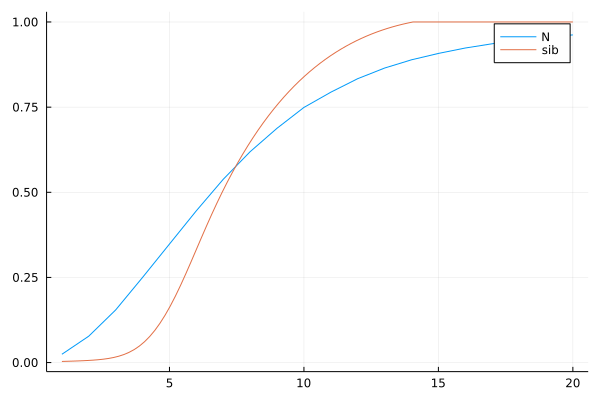

In [16]:
#Marginals

using Plots
p_cau = zeros(N,Int(T))
p_fast = zeros(N,Int(T))
for i = 1:N
    for t = 1:Int(T)
       p_cau[i,t] = marginal(i, t, statscau)
       #p_fast[i,t] = marginal(i, t, statscau_)
    end
end
i = 43
plot(p_cau[i,:], label = "N")
#plot!(p_fast[i,:], label = "N 2")
plot!(LinRange(1,Int(T),Int(round(T/dt))),p_sib[i,:], label = "sib")

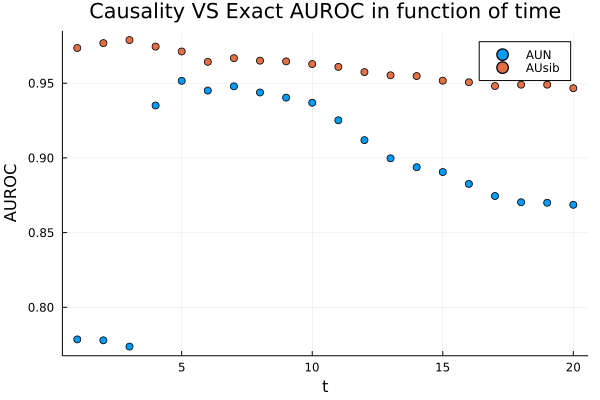

In [17]:
#AUROC curves

T = Int(T)
AU_curve=zeros(T)
AU_fast=zeros(T)
AU_sib=zeros(T)
for t = 1:T
    cau_risk=zeros(N)
    fast_risk=zeros(N)
    sib_risk = zeros(N)
    for i=1:N
       cau_risk[i] = marginal(i,t,statscau)
       #fast_risk[i] = marginal(i,t,statscau_)
       sib_risk[i] = p_sib[i,Int(round(t/dt))] 
    end
    xt = xtrue .< t
    AU_curve[t] = AUROC(ROC(xt, cau_risk))
    #AU_fast[t]  = AUROC(ROC(xt, fast_risk))
    AU_sib[t] = AUROC(ROC(xt, sib_risk))
end

scatter(LinRange(1,T,T),AU_curve, label="AUN", title="Causality VS Exact AUROC in function of time")
scatter!(LinRange(1,T,T), AU_sib, label="AUsib")
#plot!(LinRange(1,T,T), AU_fast, label="AUN2")
xlabel!("t")
ylabel!("AUROC")